In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from matplotlib import cm
from torch.utils.data import Dataset, DataLoader
from torch.tensor import Tensor
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module

from hofer import SLayer, UpperDiagonalThresholdedLogTransform, prepare_batch
         
import warnings

from sklearn.model_selection import train_test_split
%matplotlib inline

# Setting up device to use

In [2]:
device = torch.device('cuda')

# Dataset and Data Loader

In [3]:
def clean_data(data):
    data[data == -1] = 0
    data[143:167, 223:247][data[143:167, 223:247] == 0] = 1
    return data 

def resize_data(data):
    im = Image.fromarray(np.uint8(cm.gist_earth(data, alpha=None)*255)[:, :, :3])
    resized_data = np.array(im.resize((112, 76)).convert('L'))
    return resized_data/resized_data.max()

class SeaIceDataset(Dataset):
    
    def __init__(self, seq_len, data_glob=glob('./data/*.pkl'), return_dims=False):
        self.seq_len = seq_len
        self.data_files = data_glob
        self.return_dims = return_dims
        
    def __len__(self):
        return len(self.data_files) - (self.seq_len + 1)
    
    def __getitem__(self, ix):
        X = torch.tensor([resize_data(clean_data(np.array(np.load(d)))) for d in self.data_files[ix:ix+self.seq_len]], dtype=torch.float32)
        y = resize_data(clean_data(np.load(self.data_files[ix+self.seq_len+1]))).flatten().astype(np.float32)
        
        if self.return_dims:
            trans = UpperDiagonalThresholdedLogTransform(.1)
            # Read in the dim0, and dim1 data.
            dim0 = [trans(torch.tensor(np.load('./barcodes/dim0/{}'.format(d.split('/')[-1].split('.')[0] + '_dim0.npy')))) for d in self.data_files[ix:ix+self.seq_len]]
            dim1 = [trans(torch.tensor(np.load('./barcodes/dim1/{}'.format(d.split('/')[-1].split('.')[0] + '_dim1.npy')))) for d in self.data_files[ix:ix+self.seq_len]]
            return X, dim0, dim1, y
        else:
            return X, y

# Setting up Model

In [5]:
  
class autoencoder(torch.nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, 3,  padding=1),
            torch.nn.BatchNorm2d(16),# b, 16, 10, 10
            torch.nn.ReLU(True),
            torch.nn.Conv2d(16, 16, 3, padding=1),
            torch.nn.BatchNorm2d(16),# b, 16, 10, 10
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=(2,2)),
            
            torch.nn.Conv2d(16, 8, 3, padding=1),  # b, 8, 3, 3
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(8, 1, 3, padding=1),  # b, 8, 3, 3
            torch.nn.BatchNorm2d(1),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=(2,2))
        )
        self.decoder = nn.Sequential(
            torch.nn.Conv2d(1, 8, 3, padding=1),
            torch.nn.BatchNorm2d(8),# b, 16, 10, 10
            torch.nn.ReLU(True),
            torch.nn.Conv2d(8, 16, 3, padding=1),
            torch.nn.BatchNorm2d(16),# b, 16, 10, 10
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(16, 16, kernel_size=(2,2), stride=2),
            
            # b, 16, 5, 5
            torch.nn.Conv2d(16, 8, 3, padding=1),
            torch.nn.BatchNorm2d(8),# b, 16, 10, 10
            torch.nn.ReLU(True),
            torch.nn.Conv2d(8, 8, 3, padding=1),
            torch.nn.BatchNorm2d(8),# b, 16, 10, 10
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(8, 1, kernel_size=(2,2), stride=2),
#             nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    
class AutoLSTM(torch.nn.Module):
    
    def __init__(self, encoder, decoder, input_dim, batch_size, hidden_dim, seq_length, num_layers, homology=False, N=75):
        super(AutoLSTM, self).__init__()
        
        # LSTM Variables.
        self.seq_length = seq_length
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.input_size = input_dim
        
        # Homology info.
        self.homology = homology
        self.N = N
        
        # Encoder, decoder models.
        self.encoder = encoder
        self.decoder = decoder
        
        # Add the encoder to the model and turn off gradients for it.
        self.add_module('encoder', self.encoder)
        self.decoder.eval()
        for param in self.encoder.parameters():
            param.requires_grad = False
        
        # Adding decoder letting model change up its gradients.
        self.add_module('decoder', self.decoder)
        self.decoder.eval()
        for param in self.decoder.parameters():
            param.requires_grad = False
            
        # Increase input for topo signatures.
        if self.homology:
            self.input_size = self.input_size + self.N*2
            self.slayer_dim0 = SLayer(self.N)
            self.slayer_dim1 = SLayer(self.N)
        else:
            self.N = 0
            
        self.lstm = torch.nn.LSTM(self.input_size, self.hidden_dim, num_layers=self.num_layers, 
                                  batch_first=True, dropout=.1)
        self.hidden = self.init_hidden()
        
    staticmethod
    def collation_station(self, batch):
        """
        Custom collation method for joining the batchs together
        based on seq length also.
        """
        # Collate X, and y batches as normal.
        X = torch.stack([b[0] for b in batch], 0)
        y = torch.stack([torch.from_numpy(b[-1]) for b in batch], 0)
        
        # For each batch prepare the dim0 and dim1 homology features together.
        dim0_batch = []
        dim1_batch = []
        for b in batch:
            dim0_batch += b[1]
            dim1_batch += b[2]
        dim0 = prepare_batch(dim0_batch)
        del dim0_batch
        dim1 = prepare_batch(dim1_batch)
        del dim1_batch
        return X, dim0, dim1, y
        
    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.randn(self.num_layers, self.batch_size, self.hidden_dim, device=device),
                torch.randn(self.num_layers, self.batch_size, self.hidden_dim, device=device))
    
    def forward(self, x, dim0=torch.tensor([], device=device), dim1=torch.tensor([], device=device)):
        # X is (batch, seq, w, h)
        # Run inputs throuh conv nets.
        x = torch.cat([self.encoder(x[:, [ix], :, :]) for ix in range(self.seq_length)], dim=1)
        
        # Concatenate them.
        x = x.view(-1, self.seq_length, self.input_size - self.N*2)
        
        # Add the homology features.
        if self.homology:
            x = torch.cat([x, 
                           self.slayer_dim0(dim0).view(-1, self.seq_length, self.N), 
                           self.slayer_dim1(dim1).view(-1, self.seq_length, self.N)], dim=2)
            del dim0, dim1

        # Run through the lstm network.
        x, self.hidden = self.lstm(x, self.hidden)   
        
        # Run through the final decoder.
        x = self.decoder(x[:, -1, :].view(-1, 1, 19, 28))
        x = x.view(-1, 1, 8512)
        return x

# Training params

In [7]:
seq_length = 6
num_layers = 4
batch_size = 8
hidden_dim = 19*28
input_size = 19*28
N = 25
n_epochs = 25

In [8]:
auto = torch.load('autoencoder_paperv4.model')

In [9]:
model = AutoLSTM(
    homology=True, N=N,
    input_dim=input_size, seq_length=seq_length,
    hidden_dim=hidden_dim, batch_size=batch_size,
    num_layers=num_layers, encoder=auto.encoder, decoder=auto.decoder,).to(device)

all_glob = glob('./data/*.pkl')
train_glob = all_glob[:len(all_glob)-(seq_length*2)-3]
val_glob = all_glob[len(all_glob)-(seq_length*2)-3:]
print("train_size: {}, val_size: {}".format(len(train_glob), len(val_glob)))
train_dataset = SeaIceDataset(seq_length, data_glob=train_glob, return_dims=True)
val_dataset = SeaIceDataset(seq_length, data_glob=val_glob, return_dims=True)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=0, drop_last=True, collate_fn=model.collation_station)
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=batch_size, num_workers=0, drop_last=True, collate_fn=model.collation_station)

# model = torch.load('good')

optimizer = torch.optim.Adam(model.parameters(), lr=0.000001, weight_decay=1e-5)
criterion = torch.nn.MSELoss()

loss_mask = torch.tensor(np.load('resize_mask.npy').flatten().astype('float32')).cuda()

train_size: 333, val_size: 15


/uufs/chpc.utah.edu/common/home/u0897718/comp_topo/CompTopoProg/hofer.py:197: FutureWarning: Renaming in progress. In future use SLayerExponential.
  warnings.warn("Renaming in progress. In future use SLayerExponential.", FutureWarning)


# Homology Training

In [ ]:
val_storage = []
train_storage = []

In [ ]:
for epoch in range(n_epochs):
    epoch = epoch + n_epochs
    print("epoch: {}".format(epoch))
    
    model.train()
    train_losses = []
    print("Training Loop:")
    for ix, (X, dim0, dim1, y) in enumerate(train_loader):
        # Empty out the grads.
        optimizer.zero_grad()
        
        X = X.to(device)
        y = y.to(device)
        dim0 = (dim0[0].cuda(), dim0[1].cuda(), dim0[2], dim0[3])
        dim1 = (dim1[0].cuda(), dim1[1].cuda(), dim1[2], dim1[3])
        
        out = model(X, dim0, dim1)
        
        loss = criterion(out*loss_mask, y*loss_mask)
        loss.backward(retain_graph=True)
        optimizer.step()
        train_losses.append(loss.detach().item())
        
        del out, X, y, loss, dim0, dim1
    print("loss: {}".format(train_losses[-1]))
    train_storage.append(np.mean(train_losses))
    
    model.eval()
    val_losses = []
    with torch.no_grad():
        for X, dim0, dim1, y in val_loader:
            # CUDA
            X = X.to(device)
            y = y.to(device)
            dim0 = (dim0[0].cuda(), dim0[1].cuda(), dim0[2], dim0[3])
            dim1 = (dim1[0].cuda(), dim1[1].cuda(), dim1[2], dim1[3])
            
            out = model(X, dim0, dim1)
            del X, dim0, dim1
            loss = criterion(out*loss_mask, y*loss_mask)
            del y
            val_losses.append(loss.detach().item())
            del loss
        print("val_loss: {}".format(np.mean(val_losses)))
        
    val_storage.append(np.mean(val_losses))
        
    torch.save(model, './models/homology_model_e{}_l{:4f}'.format(epoch, np.mean(val_losses)))

epoch: 25
Training Loop:
loss: 0.03368135541677475
val_loss: 0.025109345093369484
epoch: 26
Training Loop:


/uufs/chpc.utah.edu/common/home/u0897718/MYTF/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type AutoLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


loss: 0.032114624977111816
val_loss: 0.023882966488599777
epoch: 27
Training Loop:
loss: 0.034410566091537476
val_loss: 0.02339307963848114
epoch: 28
Training Loop:


# Saving and plotting validation scores.

In [71]:
val_mods = glob("./models/homology_model*_l*")
vals = []
for mod in val_mods:
    vals.append(float(mod.split('_l')[1]))
vals = np.array(vals)

In [72]:
np.save('homology_val_scorse', vals)

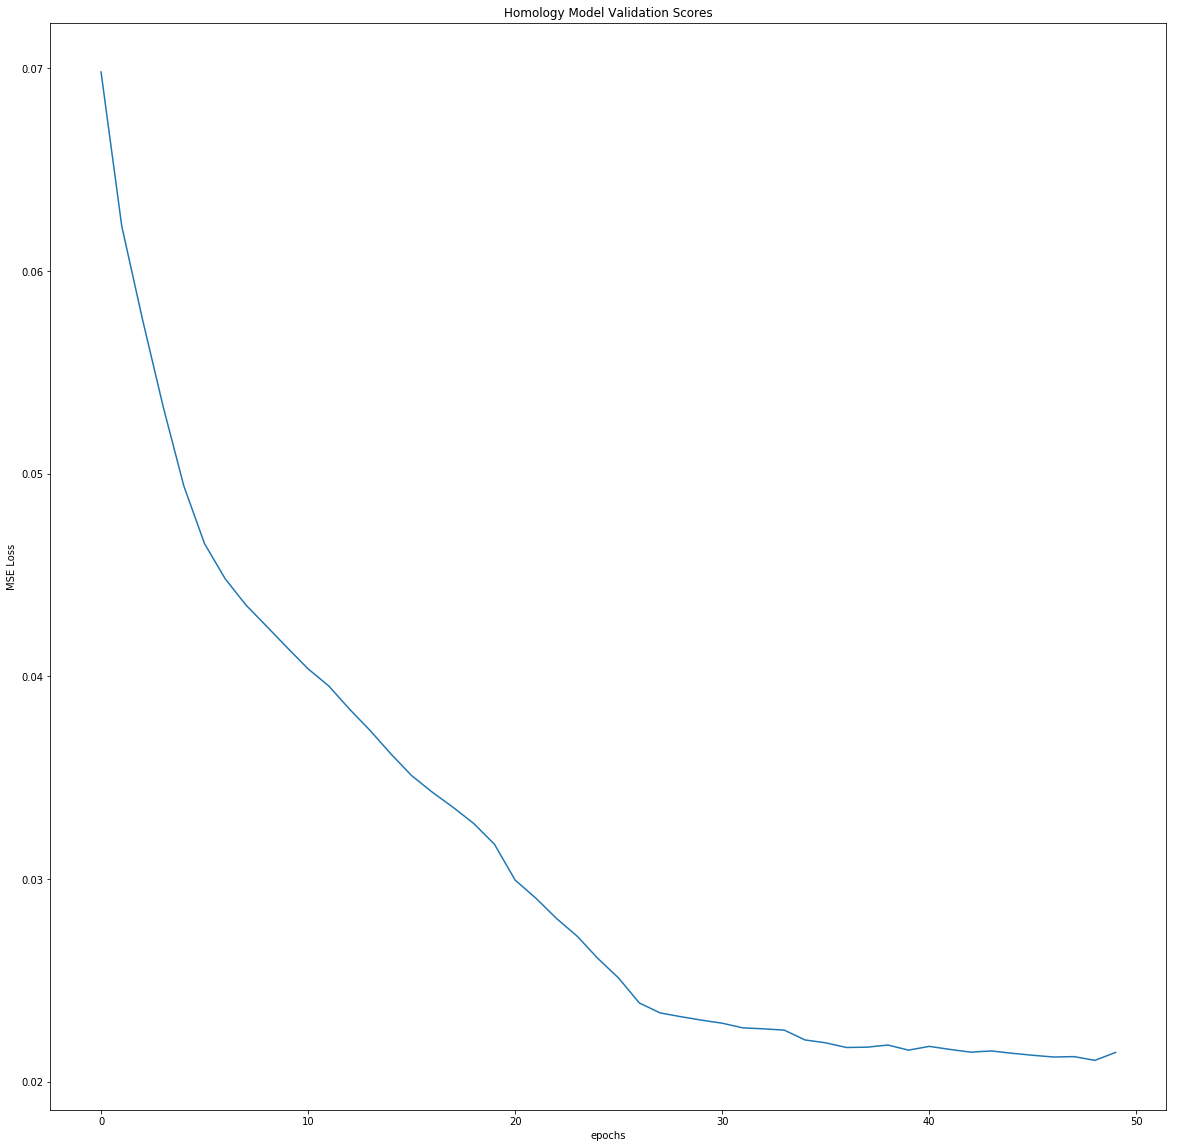

In [73]:
fig = plt.figure(figsize=(20,20))
plt.title('Homology Model Validation Scores')
plt.xlabel('epochs')
plt.ylabel('MSE Loss')
plt.plot(range(len(vals)), vals)
plt.savefig('Homology_val_plot')

In [79]:
best_mod_ix = np.argmin(vals)
model = torch.load(val_mods[best_mod_ix])
val_mods[best_mod_ix]

'./models/homology_model_e48_l0.021051'

In [47]:
for X, dim0, dim1, y in train_loader:
    X = X.cuda()
    dim0 = (dim0[0].cuda(), dim0[1].cuda(), dim0[2], dim0[3])
    dim1 = (dim1[0].cuda(), dim1[1].cuda(), dim1[2], dim1[3])
    break

In [48]:
preds = model(X, dim0, dim1)

In [49]:
cpu_X = X.cpu().numpy()

In [78]:
np.save('image_batch', cpu_X)
np.save('image_y', y.cpu().numpy())

In [86]:
batch_ix = 1

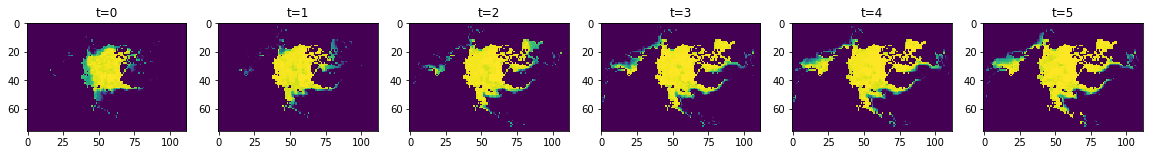

In [87]:
fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(20,20))
for ix, ax in enumerate(axs):
    ax.imshow(cpu_X[batch_ix, ix, :,:])
    ax.set_title('t={}'.format(ix))
plt.savefig('sequence.png')

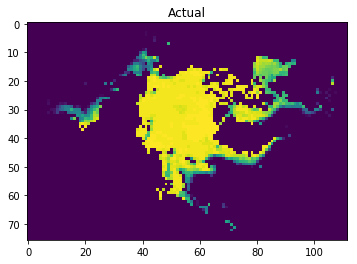

In [88]:
plt.imshow(y[batch_ix].detach().numpy().reshape(76, 112))
plt.title('Actual')
plt.savefig('actual.png')

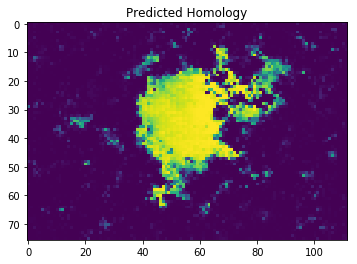

In [89]:
plt.imshow(preds[batch_ix, :, :].cpu().detach().numpy().reshape(76, 112))
plt.title("Predicted Homology")
plt.savefig('predicted_homology.png')

In [91]:
# plt.imshow(preds[1, :, :].cpu().detach().numpy().reshape(76, 112))
# plt.title("Predicted Homology")

In [92]:
# plt.imshow(preds[0, :, :].cpu().detach().numpy().reshape(76, 112))
# plt.title("Predicted Homology")